In [1]:
import json
import csv
import pandas as pd
import numpy as np 

from igraph import *
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from scipy.spatial import distance

from scipy.spatial import Delaunay


In [6]:
DIR_PATH ="graph_data/"
UBER_DIR_PATH = "uber_data/"

In [2]:
### FINAL VERSION 

## Functions for Data prep

In [3]:

def find_mean_coordinate(c):
    c = c[0]
    mean_coordinates = np.array(c if type(c[0][0]) == float else c[0]).mean(axis=0)
    return mean_coordinates

def create_geo_dataframe(json_filename):
    json_df = pd.read_json(DIR_PATH+json_filename, orient='records')
    
    # create dataframe with all feature information organized into columns
    geo_df = pd.DataFrame()
    for feature in json_df['features']:
        new_row_prop = feature['properties']
        new_row_geo = feature['geometry']
        new_row_prop.update(new_row_geo)
        geo_df = geo_df.append(pd.DataFrame.from_dict([new_row_prop], orient='columns'), ignore_index=True)

    # now calculate the mean_coordinate and add the column to the dataframe
    coordinate_list = geo_df["coordinates"].apply(find_mean_coordinate)

    #add mean_coordinate column to dataframe
    geo_df["mean_coordinate"] = coordinate_list
    
    #trim dataframe to keep only columns we need
    geo_trim_df = geo_df.drop(['TRACT','coordinates', 'type', 'DISPLAY_NAME'], axis=1)

    return geo_trim_df
    

In [4]:
def create_dataframe_from_graph(graph):
    src=[ids[0] for ids in [*graph]]
    dst=[ids[1] for ids in [*graph]]
    trvl_tm = list(graph.values())

    data = {'sourceid': src, 
              'dstid': dst,
              'mean_travel_time':trvl_tm}
    
    return pd.DataFrame.from_dict(data)



In [5]:
def find_closest_id(coor_list, long, lat):
    arr = []
    for item in coor_list:
        arr.append(item)
        
    return np.argmin(distance.cdist(arr, [[long,lat]], 'euclidean'))


## Data Preprocessing

In [7]:
json_filename = 'los_angeles_censustracts.json'
uber_filename = '/uber_dec.txt'

In [8]:
%%time
#get uber data from gcc file
uber_dec = np.loadtxt(UBER_DIR_PATH + uber_filename)

uber_dec_graph = {}
for row in uber_dec:
    location_tuple = tuple(np.sort(row[0:2]).astype('int'))
    uber_dec_graph[location_tuple] = row[2]  
    
#get location ids, we will use this as keys for finding the id of each index
uber_dec_ids = np.concatenate([uber_dec[:,0],uber_dec[:,1]])
uber_dec_ids = np.unique(uber_dec_ids).astype('int')



CPU times: user 11.7 s, sys: 254 ms, total: 12 s
Wall time: 12.1 s


In [9]:
uber_dec_df = create_dataframe_from_graph(uber_dec_graph)
uber_dec_df.head(3)

,sourceid,dstid,mean_travel_time
0,669,1638,1284.57
1,822,1620,2174.85
2,1707,1994,679.35


In [10]:
geo_trim_df = create_geo_dataframe(json_filename)
geo_trim_df.head(3)

,MOVEMENT_ID,mean_coordinate
0,1,"[-118.12053321311474, 34.103095573770496]"
1,2,"[-118.13785063157897, 34.09645121052631]"
2,3,"[-118.13138209090911, 34.09626386363636]"


In [11]:
src = [34.04 , -118.56]   
dest = [33.77 , -118.18]  


dest_id = find_closest_id(geo_trim_df["mean_coordinate"] , dest[1],dest[0])
src_id = find_closest_id(geo_trim_df["mean_coordinate"] , src[1], src[0])

print("source id: ", src_id)
print("dest id: ", dest_id)

malibu_coor = geo_trim_df.iloc[src_id].mean_coordinate
long_beach_coor = geo_trim_df.iloc[dest_id].mean_coordinate

src_id, dest_id

source id:  1522
dest id:  671


(1522, 671)

In [12]:
malibu_coor, long_beach_coor

(array([-118.54625915,   34.04840305]), array([-118.1786595,   33.7717677]))

## Question 11
    Plot the road mesh that you obtain and explain the result. Create a graph G∆ whose nodes are different locations and its edges are produced by triangulation.

In [13]:
def get_mean_coordinate(move_id_str):
    return list(geo_trim_df[geo_trim_df.MOVEMENT_ID== move_id_str]['mean_coordinate'])[0]
#     return list(geo_trim_df[geo_trim_df.MOVEMENT_ID== str(int(move_id))]['mean_coordinate'])[0]

In [14]:
# get mean_coordinate for all the location ids in the graph
mean_coor_arr= []

for location_key in uber_dec_ids:
    coor = get_mean_coordinate(str(location_key))
    mean_coor_arr.append(coor)



In [15]:
#change to 2-d array for Delaunay trianglation and plot
mean_coors = np.array(mean_coor_arr)

# get Delaunay trianglation 
tri = Delaunay(mean_coors)


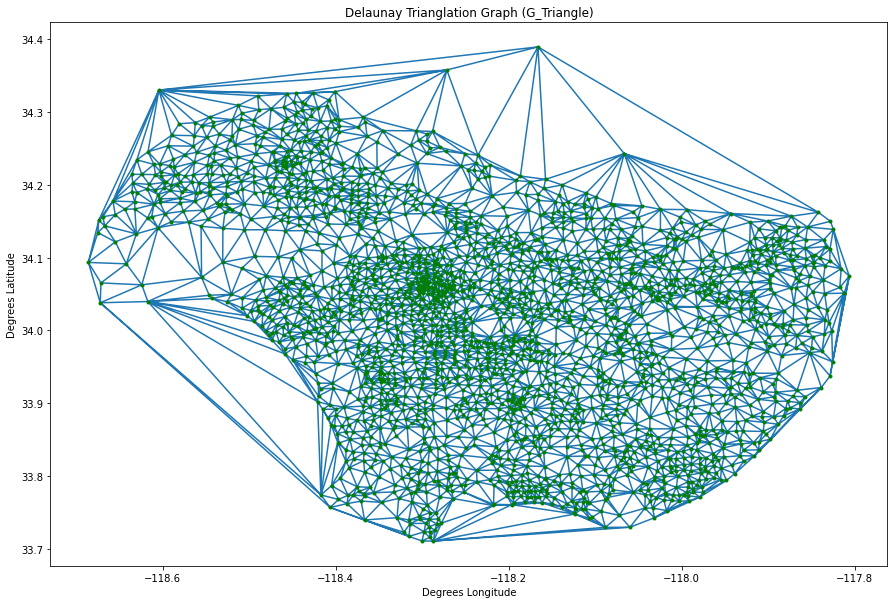

In [16]:
#create plot
plt.figure(figsize=(15,10))
plt.triplot(mean_coors[:,0], mean_coors[:,1], tri.simplices.copy())
plt.plot(mean_coors[:,0], mean_coors[:,1],'g.')

#highlight malibu and long beach in the graph with red dots
# plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=10)
# plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.', ms=10)

plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Delaunay Trianglation Graph (G_Triangle)')
plt.show()

# Question 12
    In report: See calc_flow function below

# Question 13
    Calculate the maximum number of cars that can commute per hour from Malibu to Long Beach. Also calculate the number of edge-disjoint paths between the two spots. Does the number of edge-disjoint paths match what you see on your road map?
    Source coordinates: [34.04, -118.56]
    Destination coordinates: [33.77, -118.18]

In [17]:

def get_dist_miles(loc1, loc2):
    MILES_PER_DEGREE = 69
    
    coor1 = geo_trim_df.iloc[loc1-1].mean_coordinate
    coor2 = geo_trim_df.iloc[loc2-1].mean_coordinate
    dist_latlong = np.sqrt(np.sum(np.square(coor2-coor1)))
    
    return MILES_PER_DEGREE * dist_latlong

       
def get_travel_time( loc1, loc2):
    df = uber_dec_df
    #get mean travel time b/w loc1 and loc2 from LA dataframe
    exp = (df.sourceid== loc1) & (df.dstid== loc2)
    travel_time =  df[exp].mean_travel_time
    if (len(travel_time) <= 0):
        return 0    
    return travel_time.iloc[0]

    
def calc_flow( loc1, loc2):
    travel_time_hr =  get_travel_time( loc1, loc2)/3600
    if(travel_time_hr > 0):
        #get distance from geo_df dataframe
        dist_miles = get_dist_miles(loc1, loc2)

        #calculate speed
        speed_mph = dist_miles / travel_time_hr

        #calculate flow (cars/hr) for both lanes
        flow = (2*speed_mph) / (0.003 + (speed_mph/1800))

        return flow   
    else:
        return 0
    
def add_edge(graph, triangle, indx1, indx2):
    edge_new = tuple(sorted((triangle[indx1], triangle[indx2])))
    flow_new = calc_flow(edge_new[0], edge_new[1])
#     print('(',edge_new[0], " ", edge_new[1], '): ', flow_new)

    if edge_new not in graph and flow_new > 0:
        graph[edge_new] = flow_new

def add_triangle_edges(graph, triangle):
    #get each edge as tuple (vertex1, vertex2)
    add_edge(graph, triangle, 0, 1)
    add_edge(graph, triangle, 1, 2)
    add_edge(graph, triangle, 2, 0)

    
def get_triangle(tri_indx):
    return [uber_dec_ids[tri_indx[0]], uber_dec_ids[tri_indx[1]], uber_dec_ids[tri_indx[2]]]
    

In [18]:
%%time

#create graph from Deluanay graph with flow as weights of each edge
graph_triangled = {}

for i, id_indx in enumerate(tri.simplices):
    triangle = get_triangle(id_indx)
    
    add_triangle_edges(graph_triangled, triangle)
    
    if(i%500 ==0 ):
        print(i, " of ", len(tri.simplices))


0  of  5275
500  of  5275
1000  of  5275
1500  of  5275
2000  of  5275
2500  of  5275
3000  of  5275
3500  of  5275
4000  of  5275
4500  of  5275
5000  of  5275
CPU times: user 43.7 s, sys: 2.94 s, total: 46.6 s
Wall time: 47.2 s


In [19]:
#write to txt file in case we want to use R
g_tri_filename = '/g_triangled.txt'
with open(DIR_PATH +g_tri_filename,'w') as file:
    for edge in graph_triangled:
        edge_str = '{} {} {:.2f}\n'.format(int(edge[0]), int(edge[1]), graph_triangled[edge])
        file.write(edge_str)

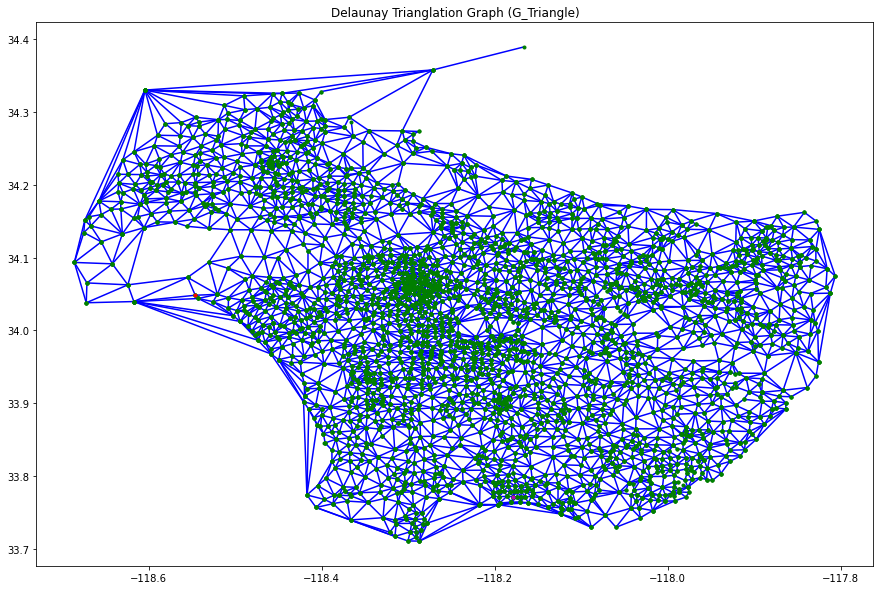

In [20]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
plt.plot(long_beach_coor[0], long_beach_coor[1], 'm.')
plt.title('Delaunay Trianglation Graph (G_Triangle)')
plt.show()


#### Extra: Zoom- In Graphs

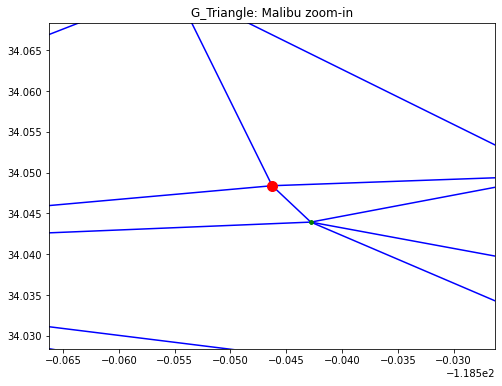

In [21]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')

points_tri_arr = np.array(points)  
plt.plot(points_tri_arr[:,0], points_tri_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'm.', ms=20)

plt.xlim(malibu_coor[0]-0.02, malibu_coor[0]+0.02)
plt.ylim(malibu_coor[1]-0.02, malibu_coor[1]+0.02)
plt.title('G_Triangle: Malibu zoom-in')

plt.show()


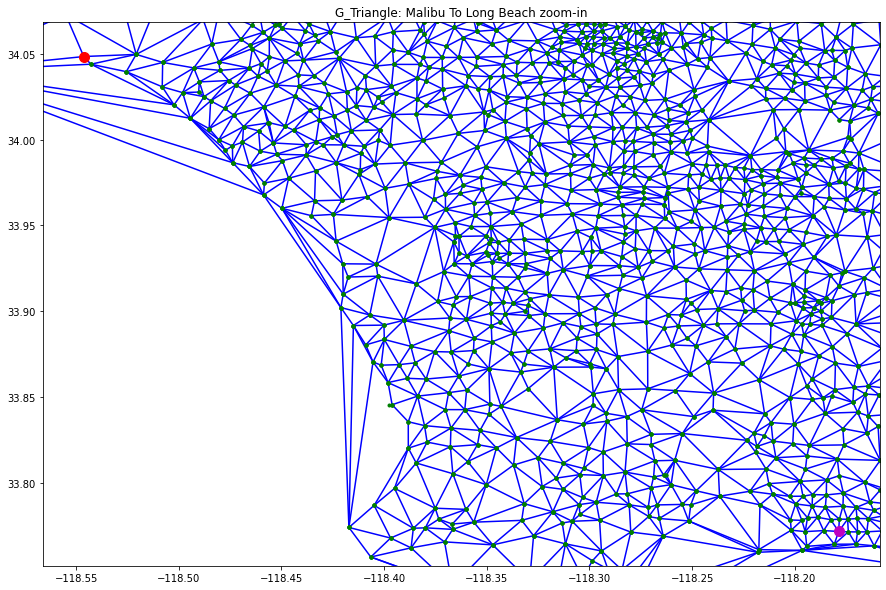

In [22]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')

points_tri_arr = np.array(points)  
plt.plot(points_tri_arr[:,0], points_tri_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'm.', ms=20)

plt.xlim(malibu_coor[0]-0.02, long_beach_coor[0]+0.02)
plt.ylim(long_beach_coor[1]-0.02, malibu_coor[1]+0.02)
plt.title('G_Triangle: Malibu To Long Beach zoom-in')

plt.show()


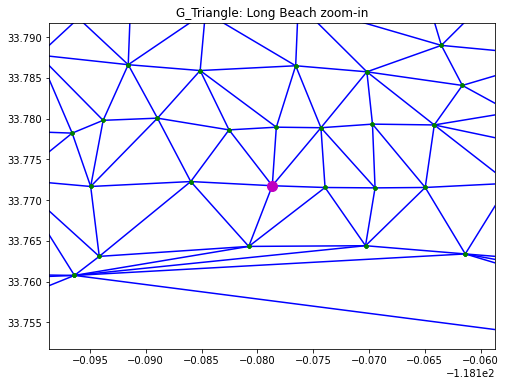

In [23]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')

points_tri_arr = np.array(points)  
plt.plot(points_tri_arr[:,0], points_tri_arr[:,1], 'g.')

plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'm.', ms=20)

plt.xlim(long_beach_coor[0]-0.02, long_beach_coor[0]+0.02)
plt.ylim(long_beach_coor[1]-0.02, long_beach_coor[1]+0.02)
plt.title('G_Triangle: Long Beach zoom-in')

plt.show()


In [24]:

def calc_path_prop(graph_filename, src_id, dest_id):
    # create graph from file
    graph = Graph.Read_Ncol(graph_filename,  directed = False)
#     summary(graph)

    #find the vertex for each id in this new graph
    ids = graph.vs['name']
    src_v = ids.index(str(src_id+1))
    dest_v = ids.index(str(dest_id+1))

    flw = graph.maxflow_value(src_v, dest_v, capacity=graph.es["weight"])
    num_paths = graph.maxflow_value(src_v, dest_v)#, capacity=graph.es["weight"])
    
    return flw, num_paths


In [25]:
# *** Question 13 Results ***
flw , num_paths = calc_path_prop(DIR_PATH + g_tri_filename, src_id, dest_id)
print("max flow: ", flw)
print("num of edge disjoint paths: ", num_paths)

max flow:  11074.130000000001
num of edge disjoint paths:  4.0


# Question 14
    Apply a threshold on the travel time of the roads in G∆ to remove the fake edges. Call the resulting graph G∆.
    QUESTION 14: Plot G∆ on actual coordinates. Do you think the thresholding method worked?

In [26]:

def add_edge_thresh(graph, triangle, indx1, indx2, thresh):
    pruned_edge = {}
    
    edge_new = tuple(sorted((triangle[indx1], triangle[indx2])))
    travel_time = get_travel_time(edge_new[0],edge_new[1])

    edge_new = tuple(sorted((triangle[indx1], triangle[indx2])))
    flow_new = calc_flow(edge_new[0], edge_new[1])
    travel_time = get_travel_time(edge_new[0],edge_new[1])

    if edge_new not in graph and flow_new > 0:
        if travel_time <= thresh:
            graph[edge_new] = flow_new
        else:
            pruned_edge[edge_new] = flow_new
    
    return pruned_edge

def add_triangle_edges_thresh(graph, triangle, thresh):
    #get each edge as tuple (vertex1, vertex2)
    pruned_edge_g = {}
    pruned_edge_g.update(add_edge_thresh(graph, triangle, 0, 1, thresh))
    pruned_edge_g.update(add_edge_thresh(graph, triangle, 1, 2, thresh))
    pruned_edge_g.update(add_edge_thresh(graph, triangle, 2, 0, thresh))
    
    return pruned_edge_g


In [27]:
%%time
graph_triangled_thresh = {}
graph_pruned ={}
# TODO: check this: current threshold: no more than 12 minutes on each intersection?
THRESHOLD = 12*60 #12*60 #np.inf

for i, id_indx in enumerate(tri.simplices):
    triangle = get_triangle(id_indx)
    
    graph_pruned.update(add_triangle_edges_thresh(graph_triangled_thresh, triangle, THRESHOLD))
    if(i%500 ==0):
        print(i, " of ", len(tri.simplices), " triangles analyzed.")
    


0  of  5275  triangles analyzed.
500  of  5275  triangles analyzed.
1000  of  5275  triangles analyzed.
1500  of  5275  triangles analyzed.
2000  of  5275  triangles analyzed.
2500  of  5275  triangles analyzed.
3000  of  5275  triangles analyzed.
3500  of  5275  triangles analyzed.
4000  of  5275  triangles analyzed.
4500  of  5275  triangles analyzed.
5000  of  5275  triangles analyzed.
CPU times: user 2min 18s, sys: 2.29 s, total: 2min 20s
Wall time: 2min 47s


In [28]:
#write to txt file in case we want to use R
g_tri_threshold_filename = '/g_tri_thresh.txt'
with open(DIR_PATH + g_tri_threshold_filename,'w') as file:
    for edge in graph_triangled_thresh:
        edge_str = '{} {} {:.2f}\n'.format(int(edge[0]), int(edge[1]), graph_triangled_thresh[edge])
        file.write(edge_str)

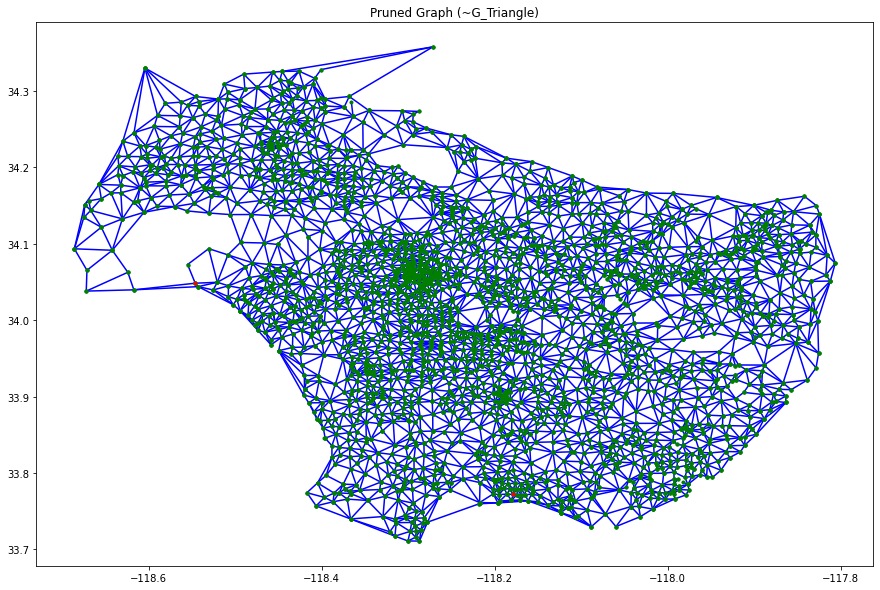

In [29]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

# #add pruned edges in another color
# for edges in graph_pruned.keys():
#     coords1 = get_mean_coordinate(str(edges[0]))
#     coords2 = get_mean_coordinate(str(edges[1]))
#     plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],'0.75', linestyle="--")

plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.title('Pruned Graph (~G_Triangle)')
plt.show()


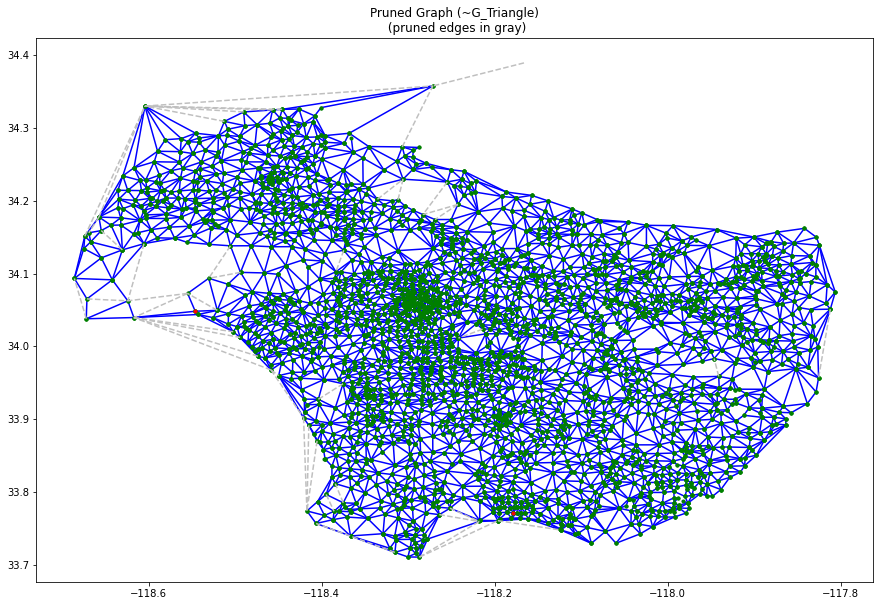

In [30]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

#add pruned edges in another color
for edges in graph_pruned.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],'0.75', linestyle="--")

plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.title('Pruned Graph (~G_Triangle)\n (pruned edges in gray)')
plt.show()


#### Extra: Zoom- In Graphs

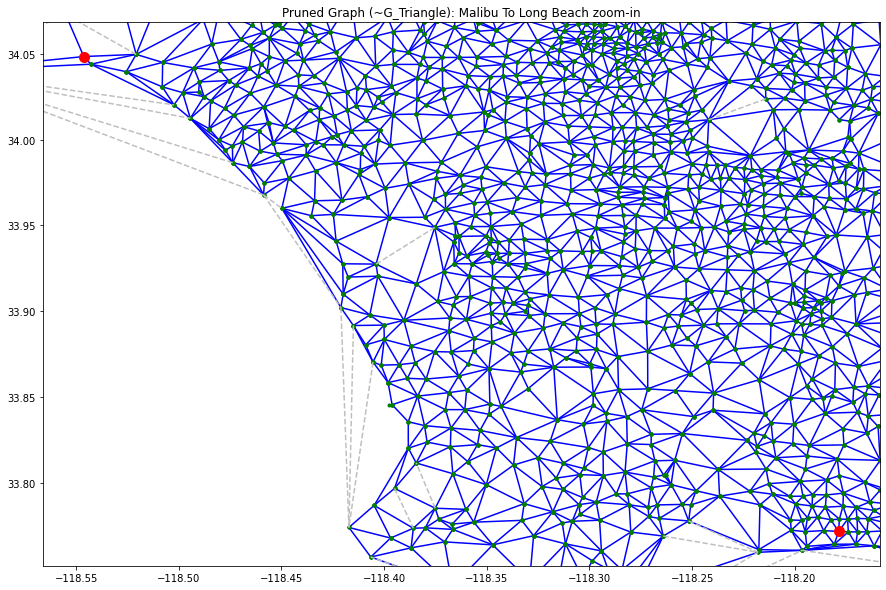

In [31]:
plt.figure(figsize=(15,10))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

#add pruned edges in another color
for edges in graph_pruned.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],'0.75', linestyle="--")


plt.plot(malibu_coor[0], malibu_coor[1], 'r.', ms=20)
plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.', ms=20)

plt.xlim(malibu_coor[0]-0.02, long_beach_coor[0]+0.02)
plt.ylim(long_beach_coor[1]-0.02, malibu_coor[1]+0.02)

plt.title('Pruned Graph (~G_Triangle): Malibu To Long Beach zoom-in')

plt.show()


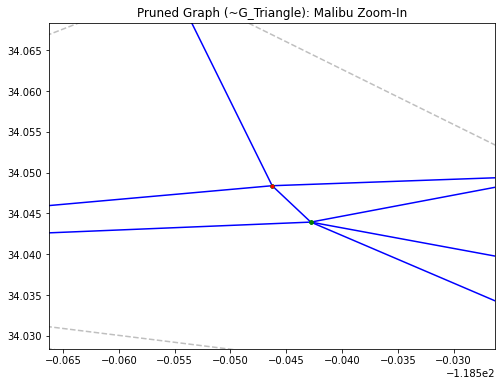

In [32]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

#add pruned edges in another color
for edges in graph_pruned.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],'0.75', linestyle="--")

    
plt.plot(malibu_coor[0], malibu_coor[1], 'r.')
# plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.xlim((malibu_coor[0]-0.02,malibu_coor[0]+0.02))
plt.ylim((malibu_coor[1]-0.02,malibu_coor[1]+0.02))

plt.title('Pruned Graph (~G_Triangle): Malibu Zoom-In')

plt.show()


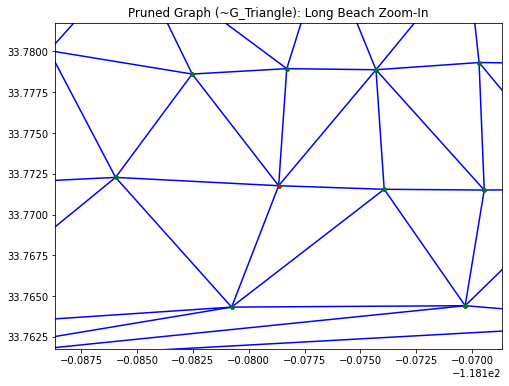

In [33]:
plt.figure(figsize=(8,6))
points=[]
for edges in graph_triangled_thresh.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    points.append(coords1)
    points.append(coords2)
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
points_thresh_arr = np.array(points)  
plt.plot(points_thresh_arr[:,0], points_thresh_arr[:,1], 'g.')

#add pruned edges in another color
for edges in graph_pruned.keys():
    coords1 = get_mean_coordinate(str(edges[0]))
    coords2 = get_mean_coordinate(str(edges[1]))
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],'0.75', linestyle="--")

plt.plot(long_beach_coor[0], long_beach_coor[1], 'r.')
plt.xlim((long_beach_coor[0]-0.01,long_beach_coor[0]+0.01))
plt.ylim((long_beach_coor[1]-0.01,long_beach_coor[1]+0.01))

plt.title('Pruned Graph (~G_Triangle): Long Beach Zoom-In')
plt.show()

In [34]:
# *** Question 15 Results ***
flw , num_paths = calc_path_prop(DIR_PATH + g_tri_threshold_filename, src_id, dest_id)
print("max flow: ", flw)
print("num of edge disjoint paths: ", num_paths)

max flow:  11074.130000000001
num of edge disjoint paths:  4.0
